<a href="https://colab.research.google.com/github/rafatb/Berlin_Airbnb_Price_Prediction/blob/main/Berlin_Airbnb_Price_Prediction_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# !pip install missingno
# !pip install autoviz
# !pip install geopy
# !pip install scipy
# !pandas_profiling
# !pip install statsmodels
# !pip install pyodbc
# !pip install seaborn
# !pip install nltk


In [8]:
import numpy as np
import os
import pandas as pd
#from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import pyodbc
import seaborn as sns
sns.set()
plt.style.use('ggplot')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import warnings
import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import nltk

In [9]:
df = pd.read_pickle('/content/drive/MyDrive/kaggle/berline/ready_for_eda.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23536 entries, 0 to 23535
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Listing ID                      23536 non-null  int64         
 1   Overall Rating                  18914 non-null  float64       
 2   Accuracy Rating                 18888 non-null  float64       
 3   Cleanliness Rating              18892 non-null  float64       
 4   Checkin Rating                  18870 non-null  float64       
 5   Communication Rating            18886 non-null  float64       
 6   Location Rating                 18871 non-null  float64       
 7   Value Rating                    18868 non-null  float64       
 8   Price                           23536 non-null  float64       
 9   Square Feet                     425 non-null    float64       
 10  Reviews                         23536 non-null  float64       
 11  re

In [10]:
df.shape
df.drop(columns=['Square Feet'], inplace=True)

#Data Protocol
###Exporting results to the protocol

In [11]:
# Type of valaues
df.dtypes.to_excel("berline_datatype.xlsx",
             sheet_name='data_type')
# Maximum valaues
df.select_dtypes(include=['float','int','category']).max().to_excel("max_berline.xlsx",
             sheet_name='max')
# Minimum Values
df.select_dtypes(include=['float','int','category']).min().to_excel("min_berline.xlsx",
             sheet_name='min')
# Missing Values
df.isnull().sum(axis=0).to_excel("NA_berline.xlsx",
             sheet_name='NA')
# exporting results to the protocol
df.nunique().to_excel("unique_berline.xlsx",
             sheet_name='unique')

#Transform data

In [12]:
df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month
df['day'] = df['review_date'].dt.day
df.drop(columns=['review_date'], inplace=True)

#TBD need to drop it in the prep
df.drop(['Neighborhood Group','Property Type'], axis=1, inplace=True)
df['Host Since'] = pd.to_datetime(df['Host Since']).dt.year



### move out non relevant data for the

In [13]:
#get dummies
df_dummy = df[[col for col in df if np.isin(df[col].dropna().unique(), [0, 1]).all()]]
df_dummy.columns

Index(['Is Superhost', 'Instant Bookable', 'Is Exact Location'], dtype='object')

In [14]:
#get all numeric data
cols = df.columns
df_num = df._get_numeric_data().columns.dropna().unique()
df_num = df_num.drop("Listing ID")
df_num

Index(['Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Price', 'Reviews', 'Bedrooms', 'Beds', 'Bathrooms',
       'Host Response Rate', 'Is Superhost', 'Latitude', 'Longitude',
       'Accomodates', 'Guests Included', 'Min Nights', 'Instant Bookable',
       'Host Since', 'Is Exact Location', 'year', 'month', 'day'],
      dtype='object')

In [15]:
pd.set_option('display.max_columns', None)
df_num_non_dummy = df[list(set(df_num)-set(df_dummy.columns))]
df_num_non_dummy.columns


Index(['Host Since', 'Guests Included', 'Location Rating', 'year',
       'Checkin Rating', 'Reviews', 'Longitude', 'Latitude', 'Beds',
       'Accuracy Rating', 'day', 'Bathrooms', 'Accomodates', 'month',
       'Overall Rating', 'Price', 'Bedrooms', 'Min Nights',
       'Host Response Rate', 'Cleanliness Rating', 'Communication Rating',
       'Value Rating'],
      dtype='object')

In [16]:
#get categorial data
df_categorial=df[list(set(cols) - set(df_num))]
df_categorial.columns

Index(['Host Response Time', 'Listing ID', 'Host Response Rate Cleansed',
       'neighbourhood', 'Neighbourhood Grouped Cleansed', 'Room Type',
       'Postal Code Cleansed', 'Property Type Cleansed'],
      dtype='object')

In [17]:
df.describe()

,Listing ID,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price,Reviews,Bedrooms,Beds,Bathrooms,Host Response Rate,Latitude,Longitude,Accomodates,Guests Included,Min Nights,Host Since,year,month,day
count,2.353600e+04,18914.000000,18888.000000,18892.000000,18870.000000,18886.000000,18871.000000,18868.000000,23536.000000,23536.000000,23516.000000,23501.000000,23507.000000,13046.000000,23536.000000,23536.000000,23536.000000,23536.000000,23536.000000,23515.000000,19380.000000,19380.000000,19380.000000
mean,1.778264e+07,94.564344,9.679850,9.334904,9.728829,9.746479,9.550315,9.417638,69.612424,19.238826,1.161720,1.641802,1.095971,91.842174,52.509906,13.406193,2.671737,1.346151,6.897774,2014.832107,2018.097162,5.526109,15.187719
std,9.887995e+06,7.599949,0.737798,1.031248,0.695275,0.679600,0.748713,0.840456,216.660408,40.360483,0.660736,1.228642,0.346150,19.447852,0.031279,0.058574,1.567812,0.856297,24.879032,2.056127,1.186035,2.915496,9.248955
min,2.695000e+03,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.345800,13.097180,1.000000,1.000000,1.000000,2008.000000,2011.000000,1.000000,1.000000
25%,9.056046e+06,92.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,32.000000,1.000000,1.000000,1.000000,1.000000,95.000000,52.489177,13.375730,2.000000,1.000000,2.000000,2013.000000,2018.000000,4.000000,7.000000
50%,1.874818e+07,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,49.000000,5.000000,1.000000,1.000000,1.000000,100.000000,52.509210,13.416575,2.000000,1.000000,3.000000,2015.000000,2019.000000,5.000000,14.000000
75%,2.587987e+07,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,75.000000,17.000000,1.000000,2.000000,1.000000,100.000000,52.532670,13.439532,3.000000,1.000000,4.000000,2016.000000,2019.000000,8.000000,23.000000
max,3.468232e+07,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9000.000000,545.000000,10.000000,22.000000,8.500000,100.000000,52.651670,13.757640,16.000000,16.000000,1000.000000,2019.000000,2019.000000,12.000000,31.000000


In [18]:
df_dummy.describe()

,Is Superhost,Instant Bookable,Is Exact Location
count,23536,23536,23536
unique,2,2,2
top,False,False,True
freq,19969,15658,17649


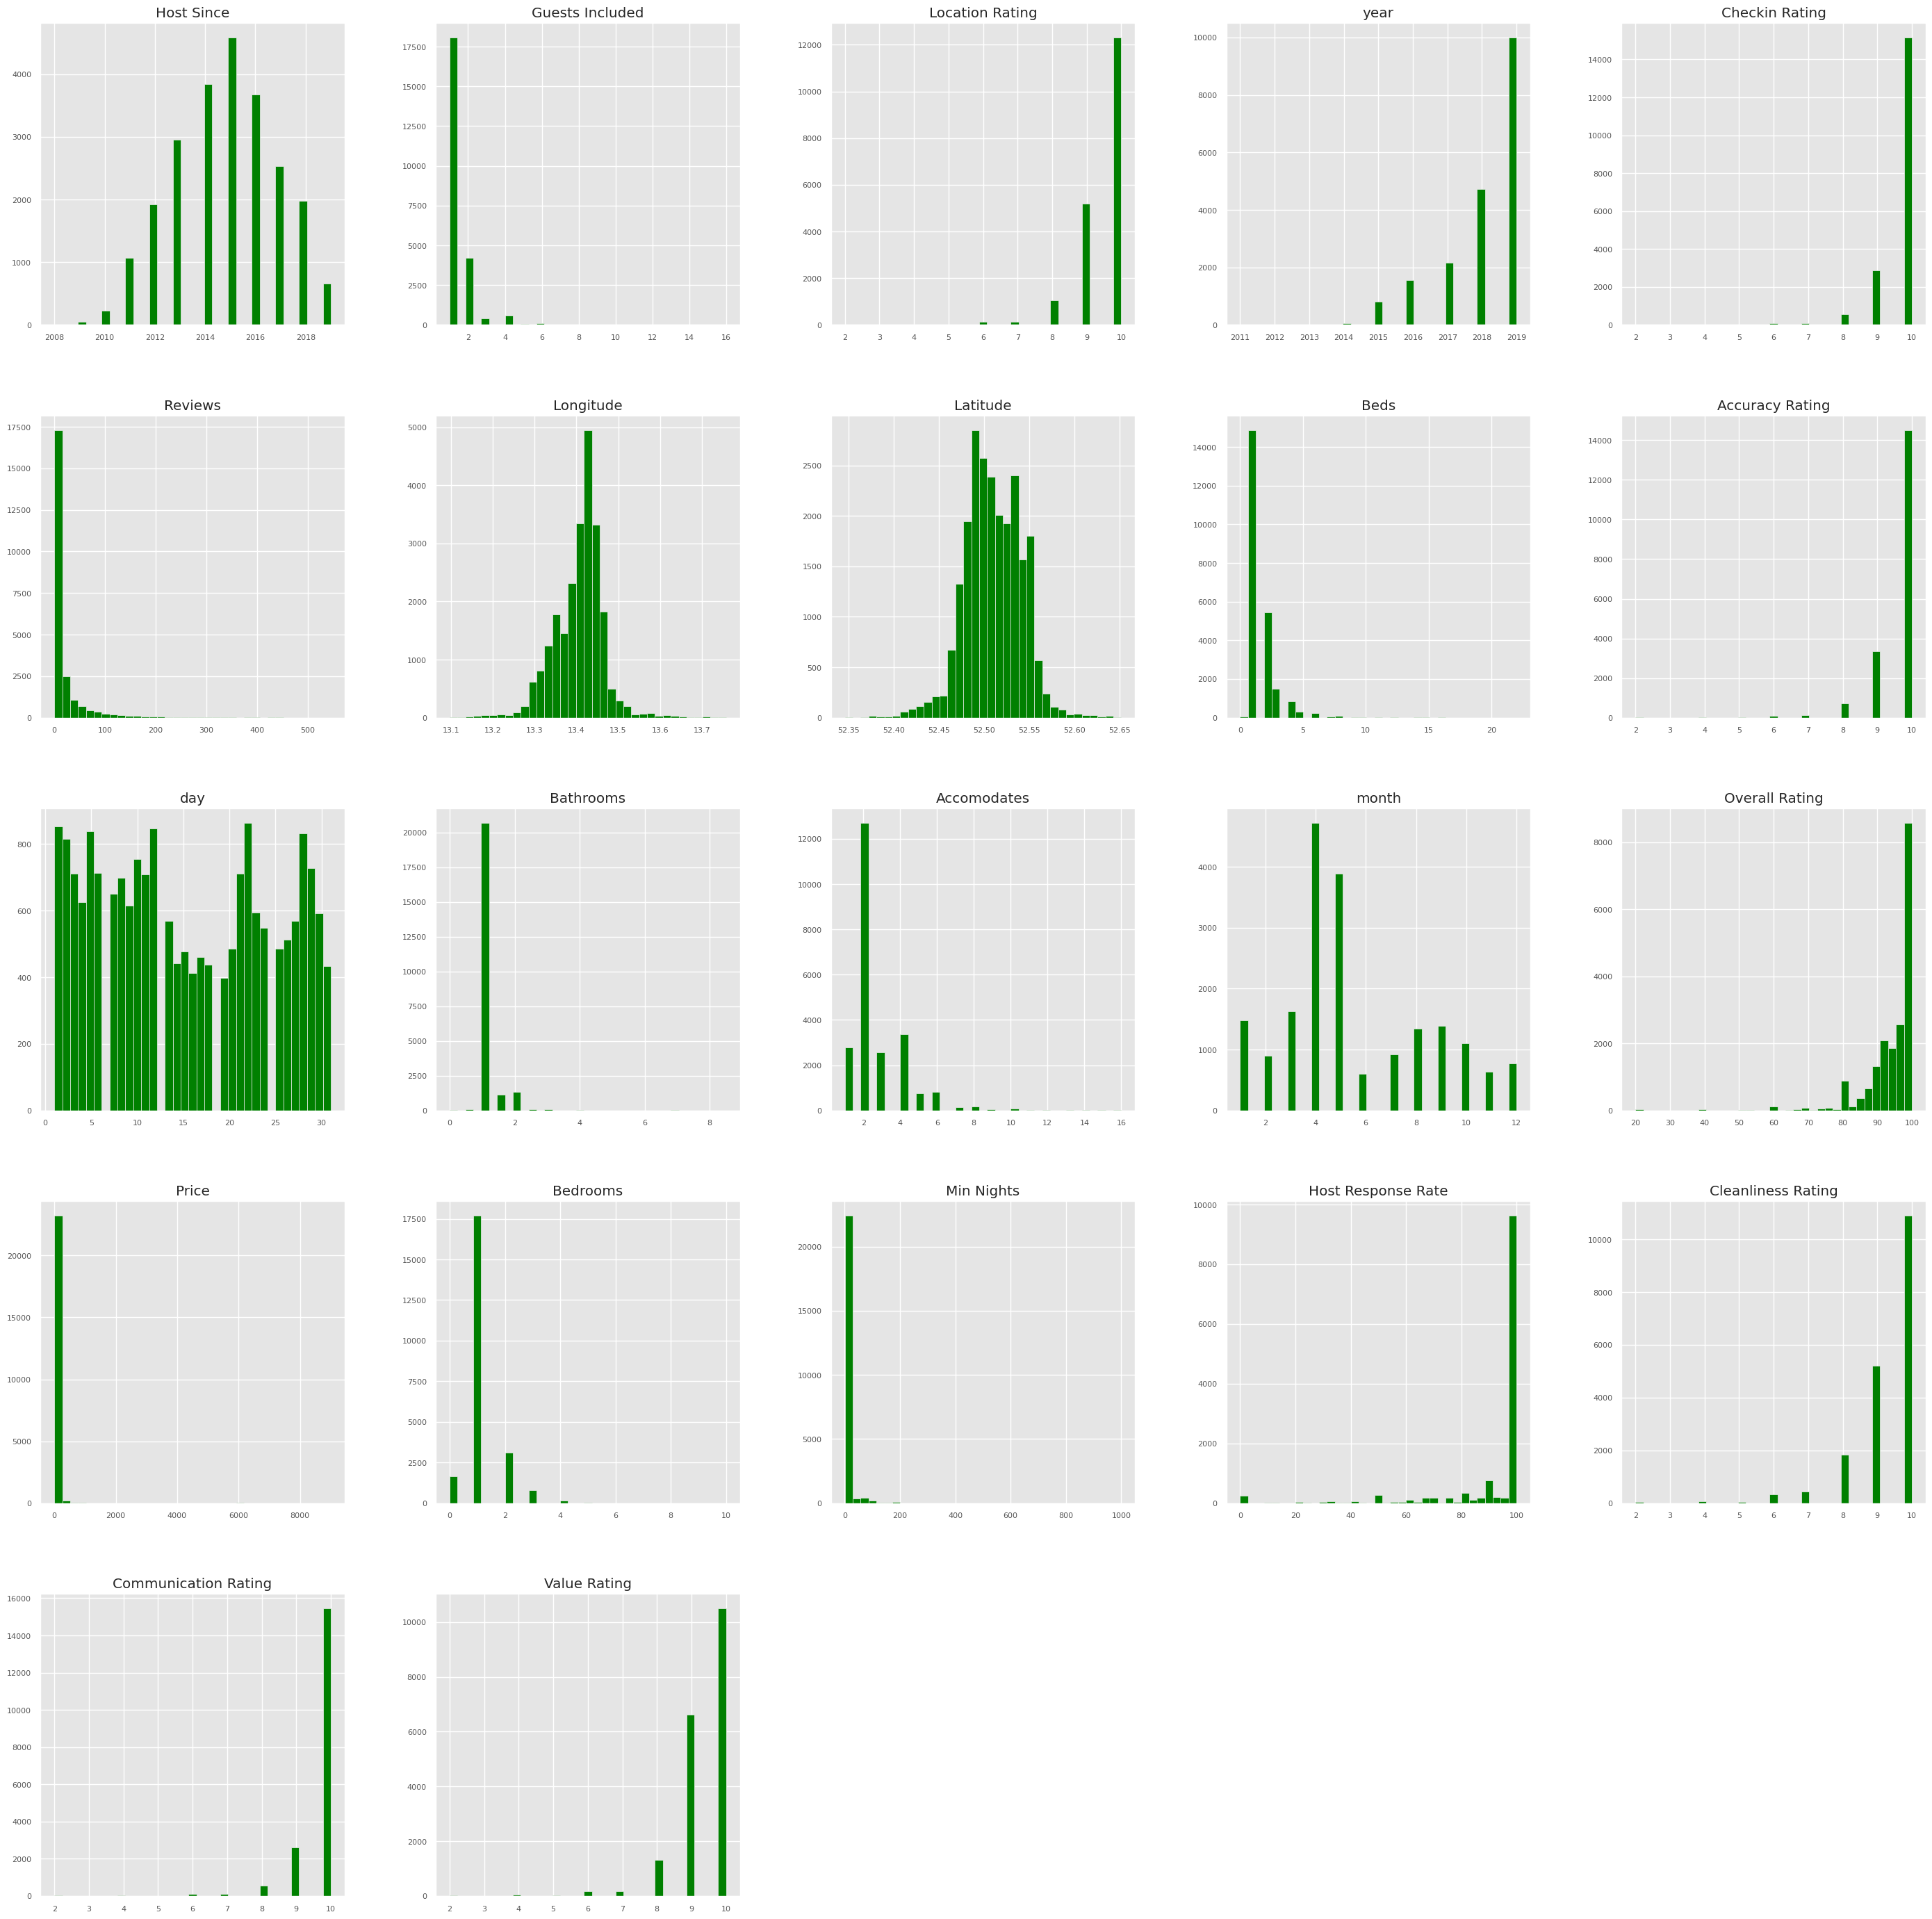

In [19]:
df_num_non_dummy.hist(figsize=(35, 35), bins=35, xlabelsize=8, ylabelsize=8, color = "green");

We can see that data is skewed, let's measure the asymmetry of the distribution:

In [20]:
def highlight(cell_value):
    highlight = 'background-color: mediumspringgreen;'
    default = ''
    negative = 'background-color: hotpink;'
    if cell_value > 1:
        return highlight
    elif cell_value < -1:
        return negative
    #else
       # return default
pd.DataFrame(df_num_non_dummy.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)

,skewness
Price,26.846364
Min Nights,21.513526
Bathrooms,6.774987
Guests Included,5.123136
Reviews,4.350674
Beds,3.661029
Accomodates,2.652933
Bedrooms,2.235585
month,0.574116
day,0.108544


we can see in the pink all the columns are positively skewed (skewness > 1), 9 columns.

in the green we can see columns are negativley skewed (skewness < -1), 10 columns.

later we'll see if outliers or missing values can affect the features distribution.

In [34]:
for i in df_dummy.columns:
 print(i)




Is Superhost
Instant Bookable
Is Exact Location


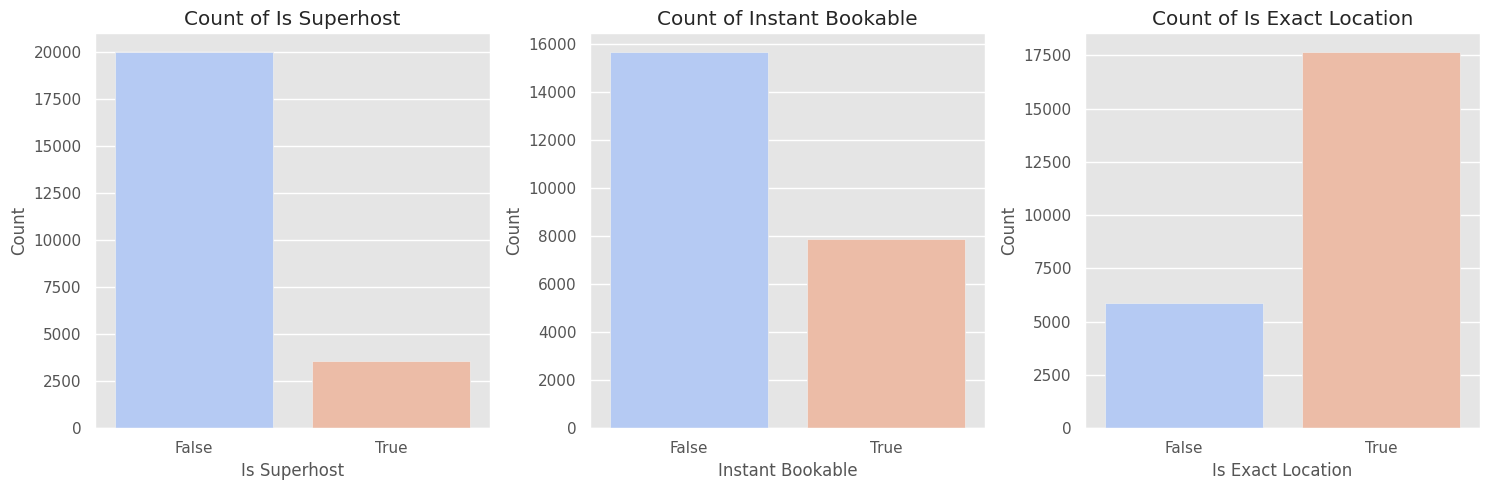

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each column and create a count plot
for i, col in enumerate(df_dummy.columns):
    sns.countplot(x=df_dummy[col], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [23]:
df_categorial

,Host Response Time,Listing ID,Host Response Rate Cleansed,neighbourhood,Neighbourhood Grouped Cleansed,Room Type,Postal Code Cleansed,Property Type Cleansed
0,within a day,2695,Low Response,Prenzlauer Berg,Pankow,Private room,10,Apartment
1,within a day,3176,Low Response,Prenzlauer Berg,Pankow,Entire home/apt,10,Apartment
2,within an hour,7071,Very High Response,Prenzlauer Berg,Pankow,Private room,10,Apartment
3,within a day,9991,Very High Response,Prenzlauer Berg,Pankow,Entire home/apt,10,Apartment
4,within a day,14325,Very High Response,Prenzlauer Berg,Pankow,Entire home/apt,10,Apartment
...,...,...,...,...,...,...,...,...
23531,within a few hours,34678365,Moderate Response,Wannsee,Steglitz - Zehlendorf,Entire home/apt,14,Apartment
23532,None,34681094,NaN,Mitte,Mitte,Private room,13,Apartment
23533,None,34681403,NaN,Britz,NeukÃ¶lln,Private room,12,Apartment
23534,None,34681413,NaN,KÃ¶penick,Treptow - KÃ¶penick,Entire home/apt,12,Apartment


In [24]:
df_categorial.shape

(23536, 8)

In [25]:
# a = 8  # number of rows
# b = 1  # number of columns
# c = 1  # plot counter

# fig = plt.figure(figsize=(50,80))
# plt.subplots_adjust(hspace = 0.1)
# sns.set(font_scale = 2.5)
# for i in df_categorial:
# #        plt.subplot(a, b, c)
#         plt.title('{}'.format(i))
#         plt.xlabel(i)
#         sns.countplot(df_categorial[i],palette="coolwarm")
#         c = c + 1

# plt.show()

In [26]:
df['Price'].describe()

,Price
count,23536.000000
mean,69.612424
std,216.660408
min,0.000000
25%,32.000000
50%,49.000000
75%,75.000000
max,9000.000000


we can aee that max price is  9000, but the 75% quantile is 75 ,
so we need to remove the extream values during the outliers phase

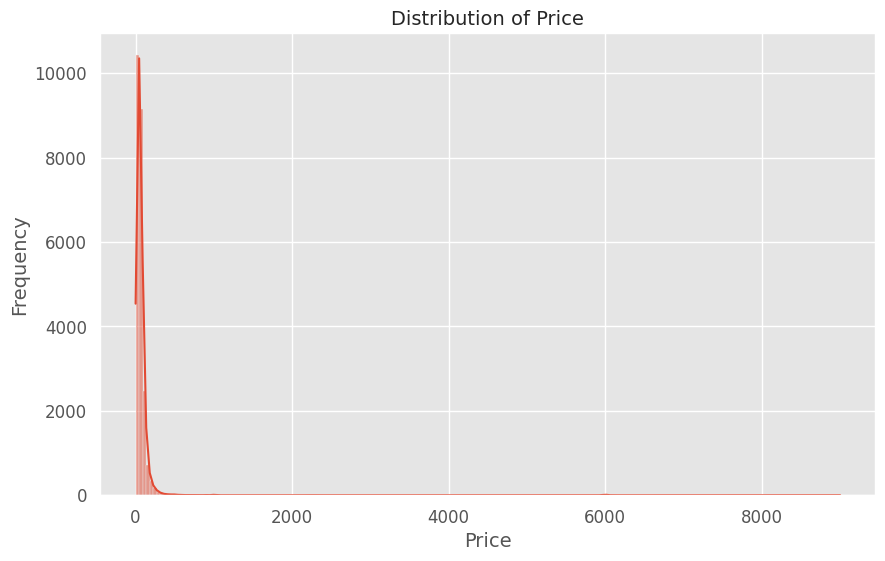

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=200, kde=True )
plt.title("Distribution of Price",fontsize=14)
plt.xlabel("Price",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.tick_params(axis='both', labelsize=12)  # 'both' for both x and y axis
plt.show()

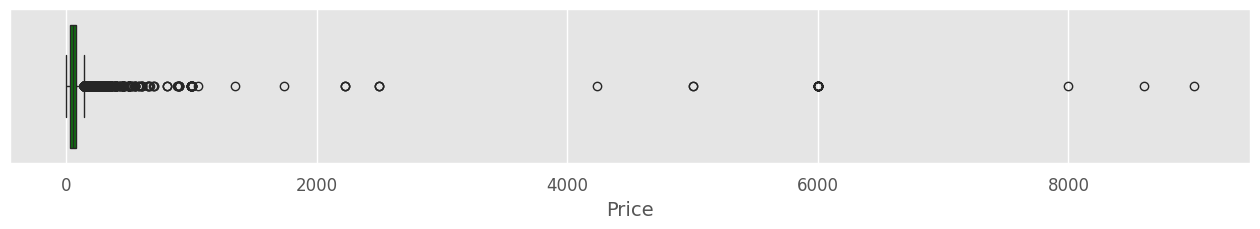

In [28]:
plt.figure(figsize=(16, 2))
sns.boxplot(df['Price'], orient='h',color='green')
plt.tick_params(axis='both', labelsize=12)  # 'both' for both x and y axis
plt.xlabel("Price",fontsize=14)
plt.show()

In [36]:
df.head()
# corr = df.corr(method = 'spearman')
# corr.style.background_gradient(cmap='coolwarm').set_precision(4)

,Listing ID,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price,Reviews,Bedrooms,Beds,Bathrooms,Host Response Rate,Is Superhost,Latitude,Longitude,Accomodates,Guests Included,Min Nights,Instant Bookable,Host Since,Is Exact Location,Host Response Time,neighbourhood,Room Type,Host Response Rate Cleansed,Neighbourhood Grouped Cleansed,Property Type Cleansed,Postal Code Cleansed,year,month,day
0,2695,100.0,10.0,10.0,10.0,10.0,9.0,10.0,17.0,7.0,1.0,1.0,1.0,50.0,False,52.54851,13.40455,2,1,2,False,2008.0,True,within a day,Prenzlauer Berg,Private room,Low Response,Pankow,Apartment,10,2019.0,4.0,21.0
1,3176,92.0,9.0,9.0,9.0,9.0,10.0,9.0,90.0,144.0,1.0,2.0,1.0,50.0,False,52.53500,13.41758,4,2,62,False,2008.0,True,within a day,Prenzlauer Berg,Entire home/apt,Low Response,Pankow,Apartment,10,2018.0,10.0,29.0
2,7071,96.0,10.0,10.0,10.0,10.0,10.0,10.0,33.0,229.0,1.0,2.0,1.0,100.0,True,52.54316,13.41509,2,1,2,False,2009.0,True,within an hour,Prenzlauer Berg,Private room,Very High Response,Pankow,Apartment,10,2019.0,5.0,8.0
3,9991,100.0,10.0,10.0,10.0,10.0,10.0,10.0,180.0,6.0,4.0,7.0,2.5,100.0,False,52.53303,13.41605,7,5,6,False,2009.0,False,within a day,Prenzlauer Berg,Entire home/apt,Very High Response,Pankow,Apartment,10,2018.0,7.0,23.0
4,14325,93.0,10.0,10.0,9.0,10.0,9.0,9.0,70.0,23.0,0.0,1.0,1.0,100.0,False,52.54785,13.40556,1,1,90,False,2009.0,True,within a day,Prenzlauer Berg,Entire home/apt,Very High Response,Pankow,Apartment,10,2018.0,11.0,1.0


### Missing values

Dataframe containing missing value counts and their frequency:

In [30]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

NameError: name 'df_nulls' is not defined

Creating a dataframe with each of the missing values as 1, while non missing values are 0:

In [ ]:
df_missing_data = (df.isna()).astype('int64')
df_missing_data.describe()

### Catigories

In [ ]:
df_categorial.describe().T

In [ ]:
# i = 1
# plt.figure(figsize=(40, 40))
# plt.subplots_adjust(hspace = 0.5)
# for col in df_categorial.columns:
#   plt.subplot(5, 2, i)
#   plt.title(f"Distribution of `{col}`", fontsize=12, fontweight="bold")
#   plt.xlabel(col, fontsize=10)
#   plt.xticks(rotation=50, fontsize=14)
#   plt.ylabel("Count")
#   sns.countplot(data=df, x=col, palette="plasma")
#   i = i + 1

# plt.tight_layout()
# plt.show()

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(30, 30))
correlation_matrix = df[df_num.union(df_dummy.columns)].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5 , annot_kws={"size": 12, "weight": "bold", "family": "monospace"})
plt.xlabel("X Features", fontsize=10)
plt.ylabel("Y Features", fontsize=10)
plt.title("Heatmap Example", fontsize=10)
plt.title("Correlation Matrix of Numerical Features")
plt.tick_params(axis='both', labelsize=10)
plt.show()

In [ ]:
plt.figure(figsize=(12, 30))
plt.subplots_adjust(hspace = 0.5)
for i, col in enumerate(df_num_non_dummy, 1):
  plt.subplot(15, 3, i)
  sns.histplot(df[col].dropna(), bins=50, kde=False)
  plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [ ]:
bar_plot_columns = ['Bedrooms', 'Bathrooms', 'Beds']
plt.figure(figsize=(14, 40))
plt.subplots_adjust(hspace = 0.5)
i = 1
for col in df_num_non_dummy.columns:
  plt.subplot(15, 2, i)
  sns.scatterplot(x=df[col], y=df['Price'], color='red')
  plt.title(f"Distribution of Price by '{col}'")

  # plt.subplot(3, 2, i+1)
  # sns.barplot(x=df[col], y=df['Price'], errcolor="red")
  # plt.title(f"Distribution of Price by '{col}'")
  # plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=2)
  # plt.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=2)

  i = i + 1
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df_categorial:
  df[f"{col} Encoded"] = le.fit_transform(df[col])

df.drop(columns=df_categorial.columns, inplace=True)
df.head()


In [ ]:
plt.figure(figsize=(30, 20))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [ ]:
corr = df.corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
from scipy import stats
df_corr= pd.DataFrame(columns=('v1','v2','abscorr','origcorr','pval'))

for i in df_num:
        for j in df_num:
                if i > j:
                        a=stats.spearmanr(df[i], df[j],nan_policy='omit')
                        b="{}/{}".format(i,j)
                        df_corr.loc[b] =[i,j,abs(a[0]),a[0],a[1]]

df_corr_filtered= df_corr.loc[(df_corr['abscorr']>0.7 ) & (df_corr['pval']<0.05)]
df_corr_filtered.sort_values(by=['abscorr'],ascending=False)

### Outliers


In [ ]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'host_is_superhost':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(df_num_non_dummy)

### Missing values

In [37]:
df_nulls = df.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls

,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Bedrooms,Beds,Bathrooms,Host Response Rate,Host Since,Host Response Time,Host Response Rate Cleansed,year,month,day
0,100.0,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,50.0,2008.0,within a day,Low Response,2019.0,4.0,21.0
1,92.0,9.0,9.0,9.0,9.0,10.0,9.0,1.0,2.0,1.0,50.0,2008.0,within a day,Low Response,2018.0,10.0,29.0
2,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,2.0,1.0,100.0,2009.0,within an hour,Very High Response,2019.0,5.0,8.0
3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,4.0,7.0,2.5,100.0,2009.0,within a day,Very High Response,2018.0,7.0,23.0
4,93.0,10.0,10.0,9.0,10.0,9.0,9.0,0.0,1.0,1.0,100.0,2009.0,within a day,Very High Response,2018.0,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,75.0,2018.0,within a few hours,Moderate Response,NaN,NaN,NaN
23532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,NaN,2019.0,None,NaN,NaN,NaN,NaN
23533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.5,NaN,2014.0,None,NaN,NaN,NaN,NaN
23534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,1.0,NaN,2019.0,None,NaN,NaN,NaN,NaN


<Axes: >

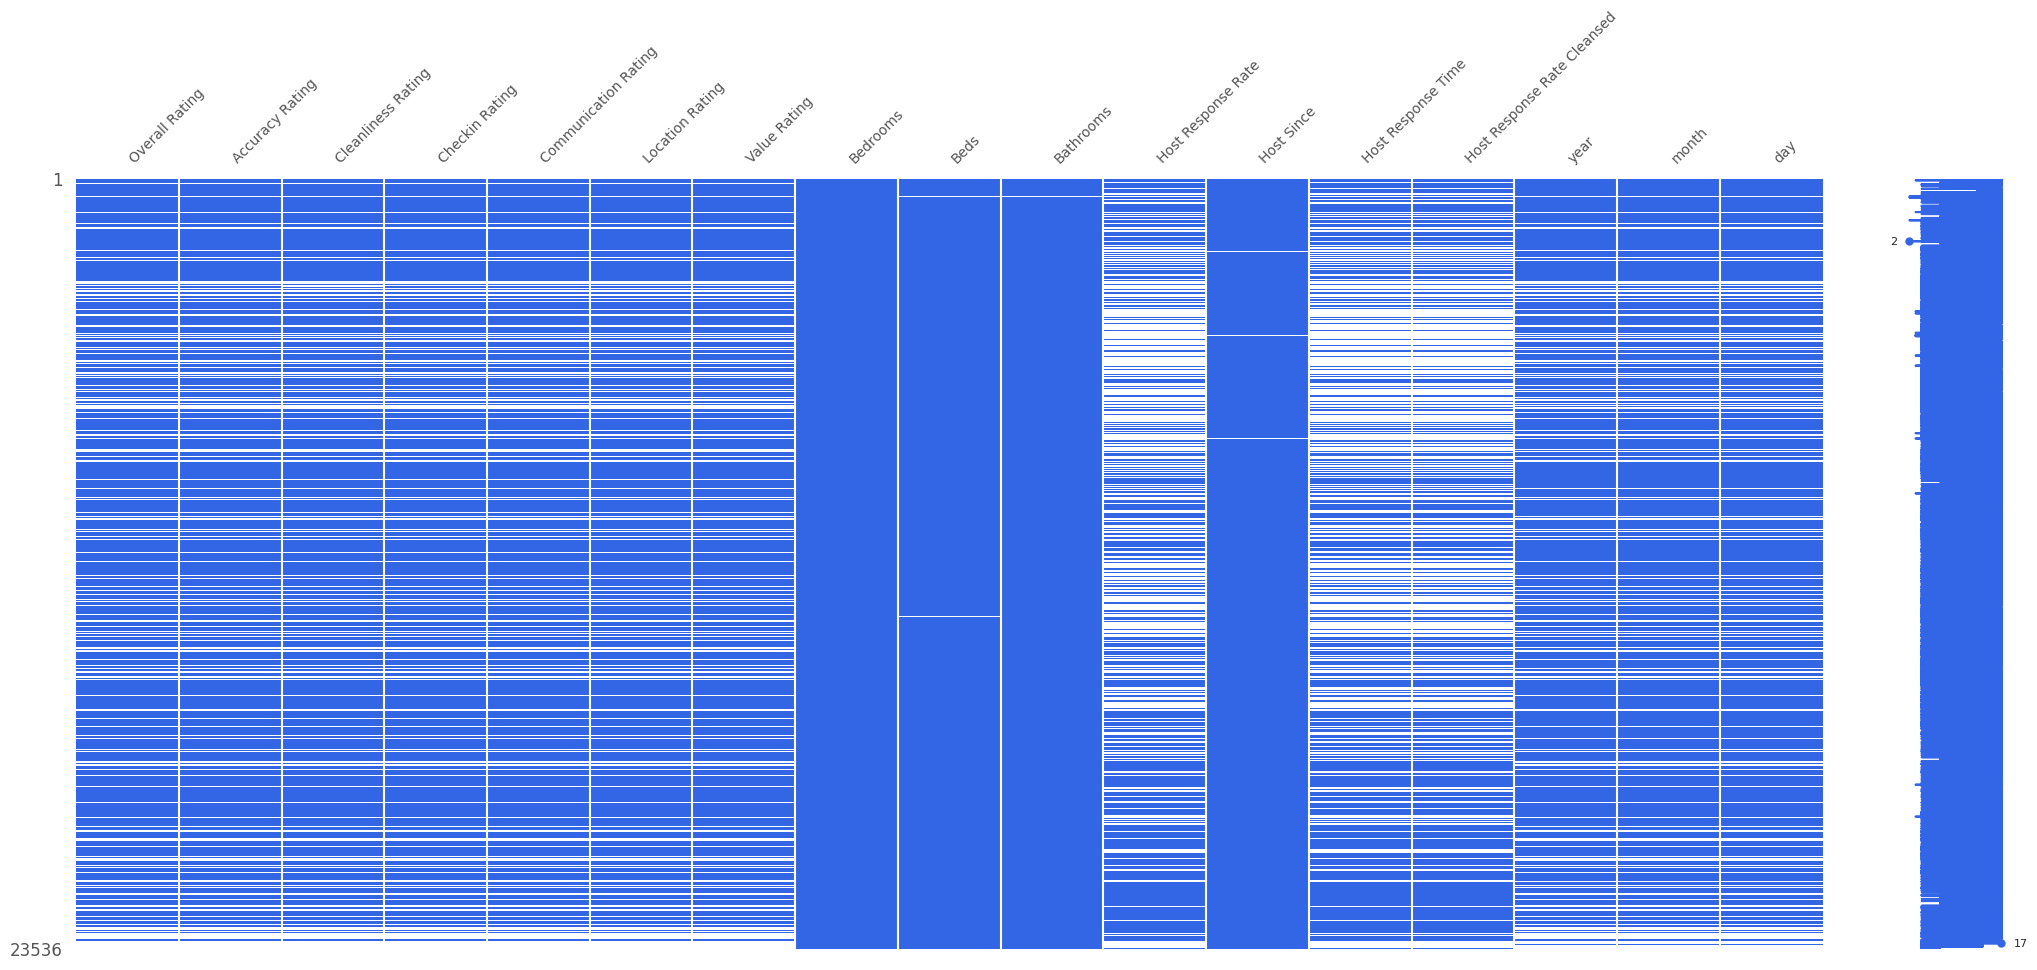

In [38]:
msno.matrix(df_nulls,color=(0.2, 0.4, 0.9),fontsize=10)

Dataframe containing missing value counts and their frequency:

In [39]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_per
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
     '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

,Missing Values,% of Total Values
Host Response Time,10490,44.6
Host Response Rate,10490,44.6
Host Response Rate Cleansed,10490,44.6
Value Rating,4668,19.8
Checkin Rating,4666,19.8
Location Rating,4665,19.8
Communication Rating,4650,19.8
Accuracy Rating,4648,19.7
Cleanliness Rating,4644,19.7
Overall Rating,4622,19.6


Creating a dataframe with each of the missing values as 1, while non missing values are 0:

In [50]:
pd.set_option('display.max_columns', None)
df_missing_data = (df.isna()).astype('int64')
df_missing_data.describe()

,Listing ID,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price,Reviews,Bedrooms,Beds,Bathrooms,Host Response Rate,Is Superhost,Latitude,Longitude,Accomodates,Guests Included,Min Nights,Instant Bookable,Host Since,Is Exact Location,Host Response Time,neighbourhood,Room Type,Host Response Rate Cleansed,Neighbourhood Grouped Cleansed,Property Type Cleansed,Postal Code Cleansed,year,month,day
count,23536.0,23536.000000,23536.000000,23536.000000,23536.000000,23536.000000,23536.000000,23536.000000,23536.0,23536.0,23536.000000,23536.000000,23536.000000,23536.000000,23536.0,23536.0,23536.0,23536.0,23536.0,23536.0,23536.0,23536.000000,23536.0,23536.000000,23536.0,23536.0,23536.000000,23536.0,23536.0,23536.0,23536.000000,23536.000000,23536.000000
mean,0.0,0.196380,0.197485,0.197315,0.198249,0.197570,0.198207,0.198334,0.0,0.0,0.000850,0.001487,0.001232,0.445700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000892,0.0,0.445700,0.0,0.0,0.445700,0.0,0.0,0.0,0.176581,0.176581,0.176581
std,0.0,0.397268,0.398110,0.397980,0.398690,0.398174,0.398657,0.398754,0.0,0.0,0.029139,0.038535,0.035081,0.497053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029858,0.0,0.497053,0.0,0.0,0.497053,0.0,0.0,0.0,0.381321,0.381321,0.381321
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000


### Data Cleansing

<Axes: >

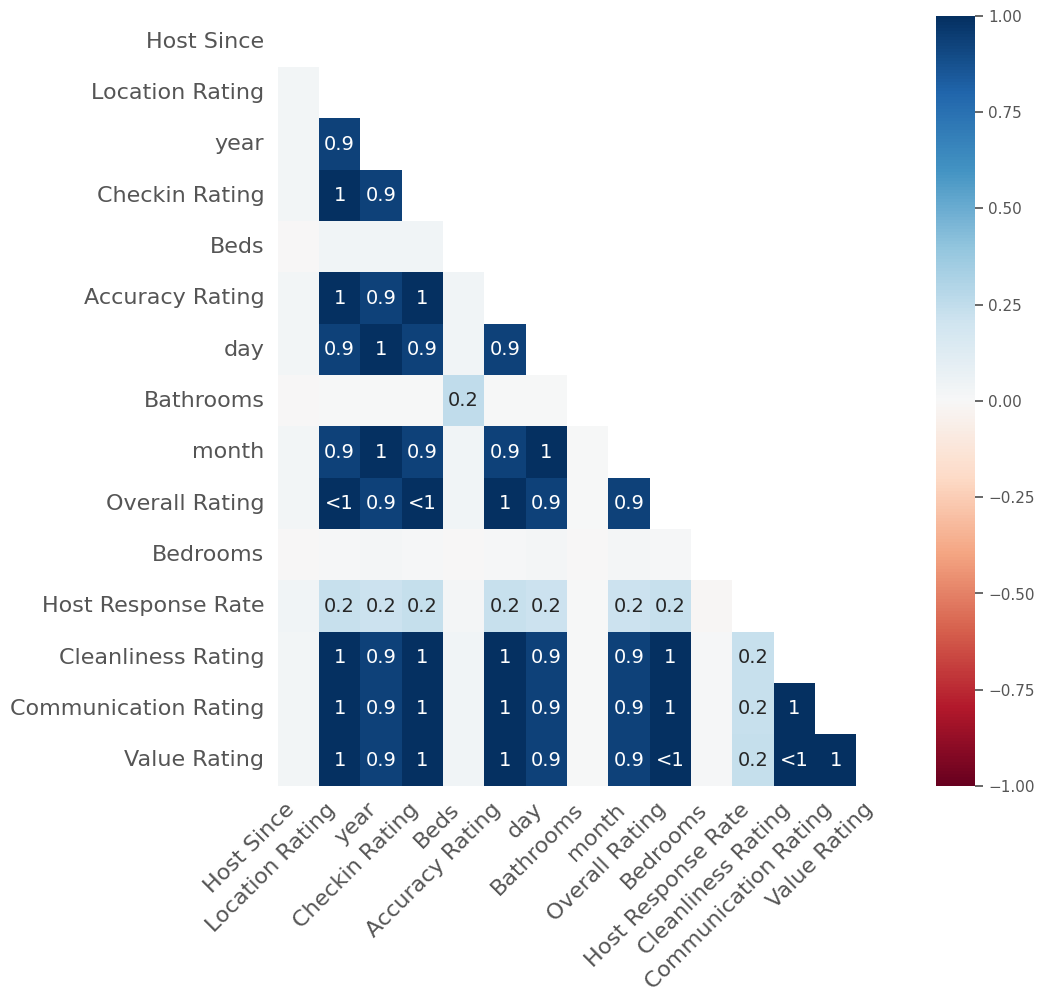

In [41]:
msno.heatmap(df_num_non_dummy,figsize=(10,10))

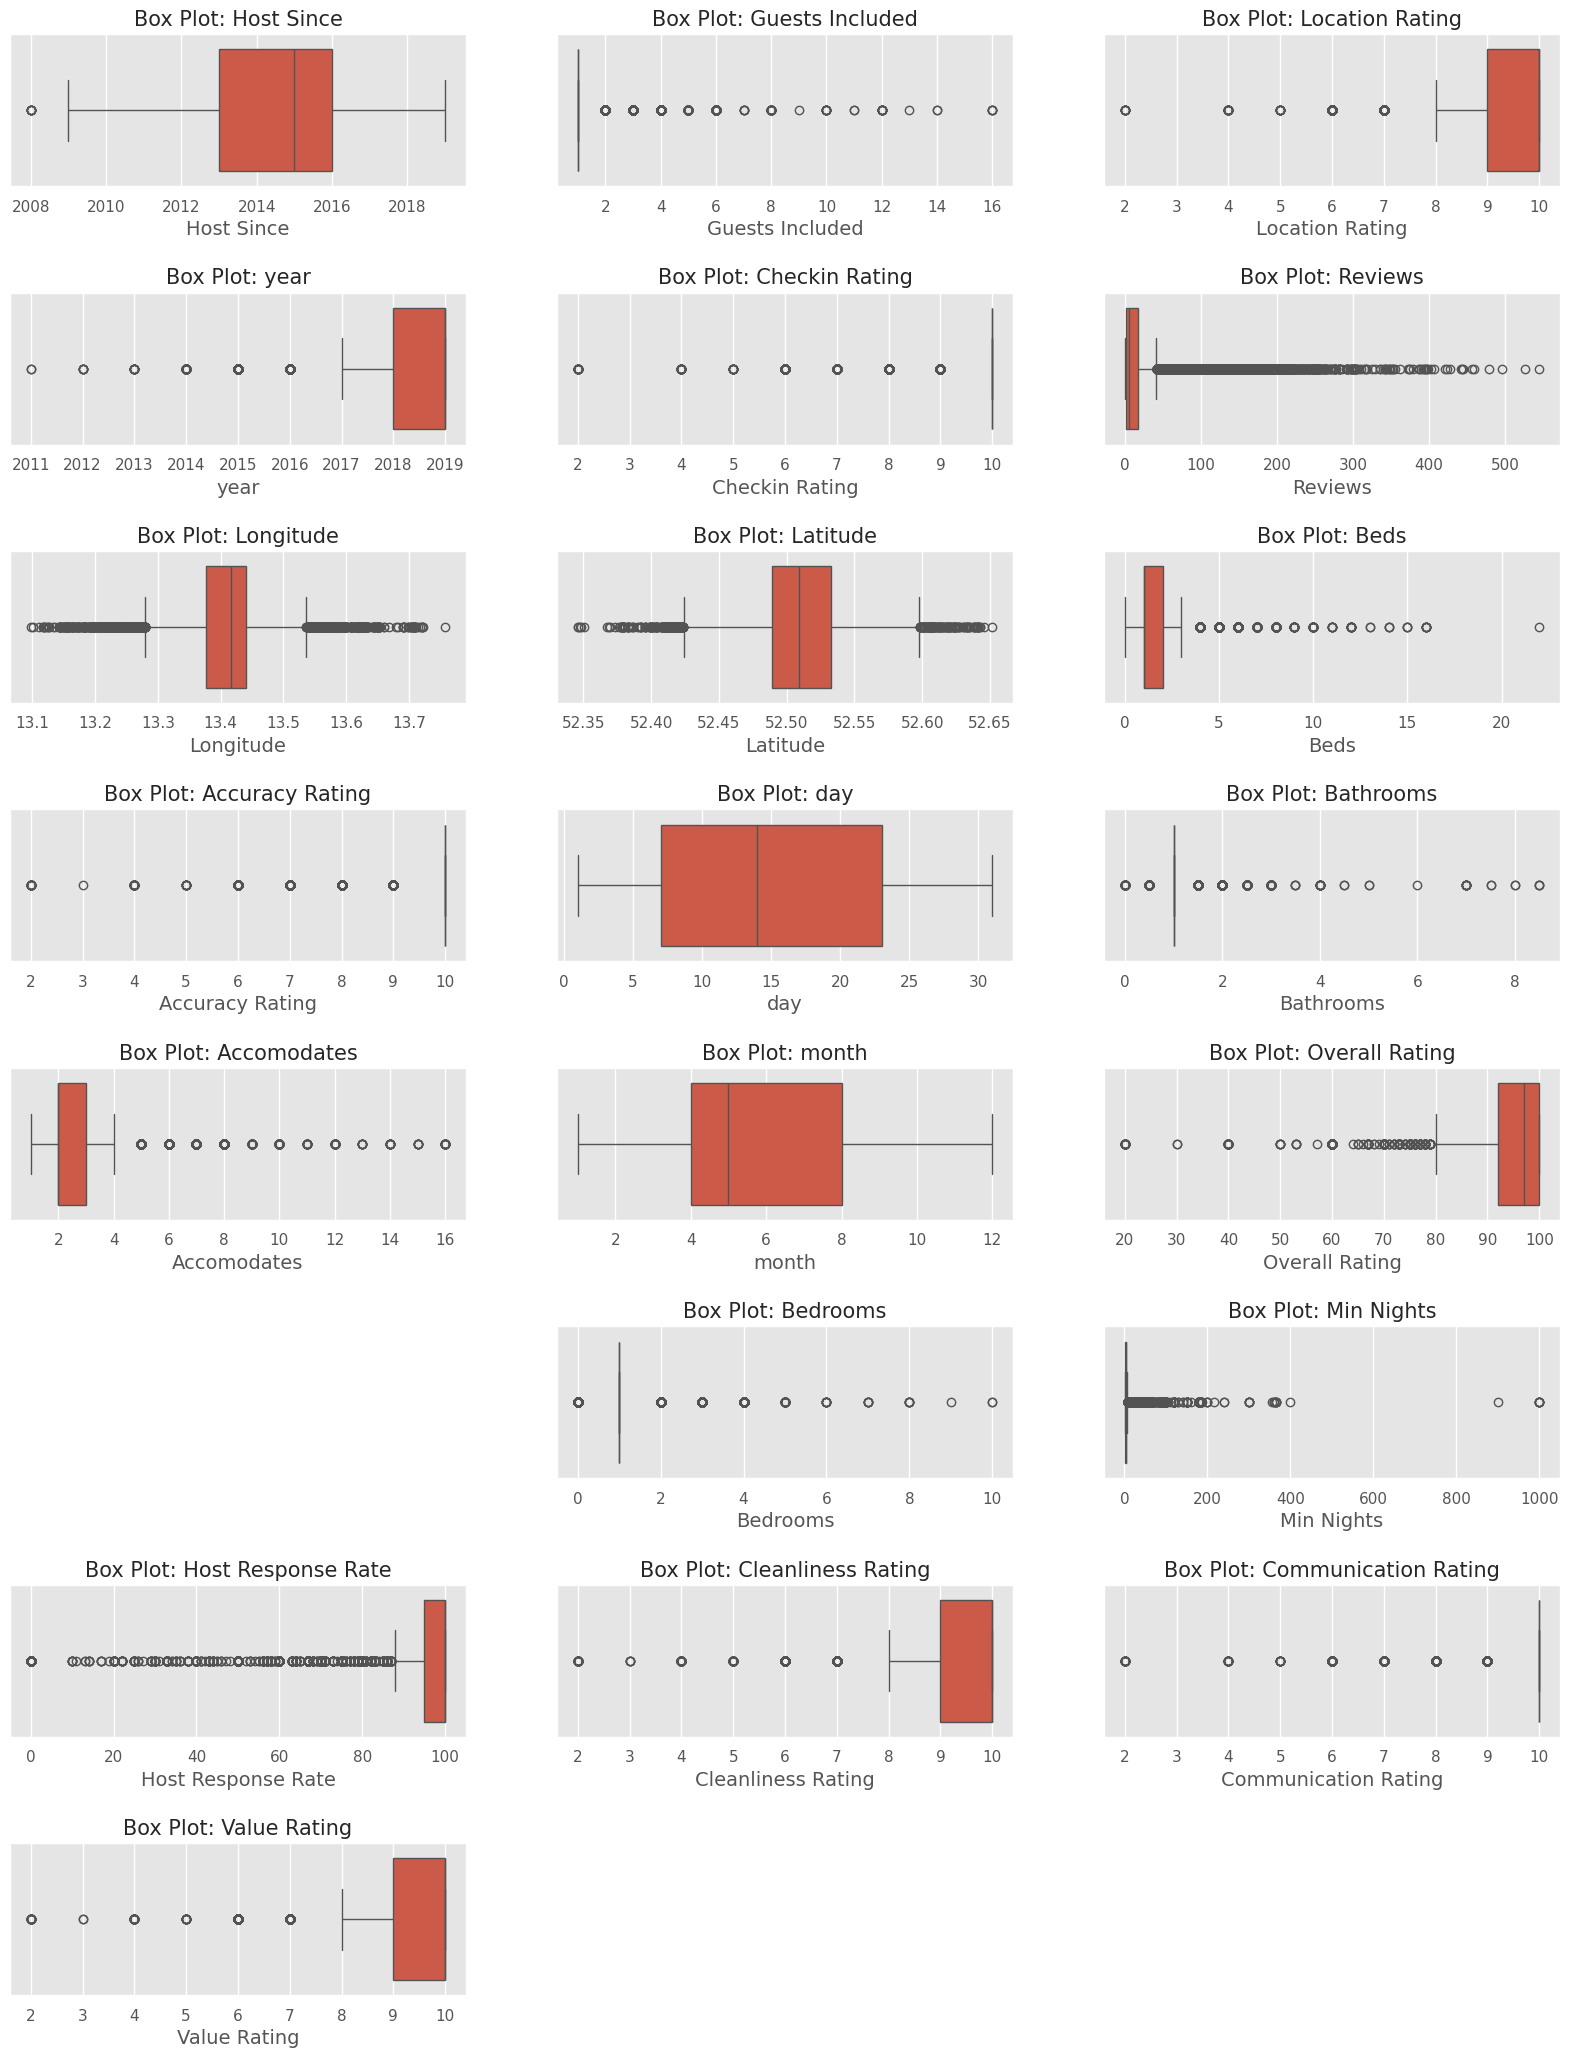

In [42]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'Price':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(df_num_non_dummy)

### outliers_df
The data is skewed and not normaly distributed, we'll use the IQR method to identify outliers to set up a boundary before Q1 and after Q3. Any values that fall outside of this boundary are considered outliers:

In [55]:
def outliers_df(df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])

    for col in df:  # Ensure processing numeric columns only
      if (col != "Price"):
        temp = pd.DataFrame(df[col])
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        # Filter rows that are outliers in either direction
        temp_outliers = temp[(temp[col] > upper_limit) | (temp[col] < lower_limit)]
        num_outliers = len(temp_outliers)
        total_outliers.loc[col] = [num_outliers, num_outliers / len(df) * 100]

    return total_outliers[total_outliers['Percent'] > 0]

# Assume con_df is your DataFrame
# Call the function and sort results
outliers_df = outliers_df(df_num_non_dummy).sort_values('Percent', ascending=False)
outliers_df

,Outlier count,Percent
Bedrooms,5810.0,24.685588
Guests Included,5447.0,23.143270
Accuracy Rating,4367.0,18.554555
Checkin Rating,3700.0,15.720598
Communication Rating,3423.0,14.543678
Reviews,2983.0,12.674201
Bathrooms,2813.0,11.951903
Min Nights,2520.0,10.707002
year,2473.0,10.507308
Host Response Rate,2188.0,9.296397


### new_outliers_df
Labeling every outlier with 'Outlier' in order to seperate the outliers from nulls (temporarily, and then to 0/1):

In [56]:
def outliers(df):
    label_out_df = df.copy()
    for col in label_out_df:
      if (col != "Price"):
        if col in outliers_df.index:
            Q1 = label_out_df[col].quantile(0.25)
            Q3 = label_out_df[col].quantile(0.75)
            upper_limit = Q1 - 1.5 * (Q3-Q1)
            lower_limit = Q3 + 1.5 * (Q3-Q1)
            label_out_df[col] = np.where(label_out_df[col] > upper_limit,'Outlier',np.where(label_out_df[col] < lower_limit,'Outlier',label_out_df[col]))
    return label_out_df
new_df_outliers = outliers(df)
new_df_outliers.head(10)

,Listing ID,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price,Reviews,Bedrooms,Beds,Bathrooms,Host Response Rate,Is Superhost,Latitude,Longitude,Accomodates,Guests Included,Min Nights,Instant Bookable,Host Since,Is Exact Location,Host Response Time,neighbourhood,Room Type,Host Response Rate Cleansed,Neighbourhood Grouped Cleansed,Property Type Cleansed,Postal Code Cleansed,year,month,day
0,2695,Outlier,10.0,Outlier,10.0,10.0,Outlier,Outlier,17.0,Outlier,1.0,Outlier,1.0,Outlier,False,Outlier,Outlier,Outlier,1,Outlier,False,Outlier,True,within a day,Prenzlauer Berg,Private room,Low Response,Pankow,Apartment,10,Outlier,4.0,21.0
1,3176,Outlier,Outlier,Outlier,Outlier,Outlier,Outlier,Outlier,90.0,Outlier,1.0,Outlier,1.0,Outlier,False,Outlier,Outlier,Outlier,Outlier,Outlier,False,Outlier,True,within a day,Prenzlauer Berg,Entire home/apt,Low Response,Pankow,Apartment,10,Outlier,10.0,29.0
2,7071,Outlier,10.0,Outlier,10.0,10.0,Outlier,Outlier,33.0,Outlier,1.0,Outlier,1.0,Outlier,True,Outlier,Outlier,Outlier,1,Outlier,False,Outlier,True,within an hour,Prenzlauer Berg,Private room,Very High Response,Pankow,Apartment,10,Outlier,5.0,8.0
3,9991,Outlier,10.0,Outlier,10.0,10.0,Outlier,Outlier,180.0,Outlier,Outlier,Outlier,Outlier,Outlier,False,Outlier,Outlier,Outlier,Outlier,Outlier,False,Outlier,False,within a day,Prenzlauer Berg,Entire home/apt,Very High Response,Pankow,Apartment,10,Outlier,7.0,23.0
4,14325,Outlier,10.0,Outlier,Outlier,10.0,Outlier,Outlier,70.0,Outlier,Outlier,Outlier,1.0,Outlier,False,Outlier,Outlier,Outlier,1,Outlier,False,Outlier,True,within a day,Prenzlauer Berg,Entire home/apt,Very High Response,Pankow,Apartment,10,Outlier,11.0,1.0
5,16401,nan,nan,nan,nan,nan,nan,nan,120.0,Outlier,1.0,Outlier,1.0,nan,False,Outlier,Outlier,Outlier,1,Outlier,False,Outlier,True,None,Friedrichshain,Private room,NaN,Friedrichshain-Kreuzberg,Apartment,10,nan,NaN,NaN
6,16644,Outlier,10.0,Outlier,10.0,10.0,Outlier,Outlier,90.0,Outlier,1.0,Outlier,1.0,nan,False,Outlier,Outlier,Outlier,Outlier,Outlier,False,Outlier,True,None,Kreuzberg,Entire home/apt,NaN,Friedrichshain-Kreuzberg,Apartment,10,Outlier,12.0,14.0
7,17904,Outlier,10.0,Outlier,10.0,10.0,Outlier,Outlier,49.0,Outlier,nan,Outlier,1.0,Outlier,False,Outlier,Outlier,Outlier,1,Outlier,False,Outlier,False,within an hour,NeukÃ¶lln,Entire home/apt,Very High Response,NeukÃ¶lln,Apartment,12,Outlier,4.0,17.0
8,20858,Outlier,Outlier,Outlier,Outlier,Outlier,Outlier,Outlier,129.0,Outlier,Outlier,Outlier,1.0,Outlier,False,Outlier,Outlier,Outlier,Outlier,Outlier,False,Outlier,True,within an hour,Prenzlauer Berg,Entire home/apt,Very High Response,Pankow,Loft,10,Outlier,4.0,15.0
9,21869,Outlier,Outlier,Outlier,10.0,Outlier,Outlier,Outlier,70.0,Outlier,1.0,Outlier,1.0,nan,False,Outlier,Outlier,Outlier,Outlier,Outlier,False,Outlier,True,None,Kreuzberg,Entire home/apt,NaN,Friedrichshain-Kreuzberg,Apartment,10,Outlier,6.0,5.0


Creating a dataframe with outliers as 1 and non-outliers as 0:

In [57]:
df_outliers = new_df_outliers.isin(['Outlier'])
df_outliers = df_outliers.astype('int')
df_outliers

,Listing ID,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price,Reviews,Bedrooms,Beds,Bathrooms,Host Response Rate,Is Superhost,Latitude,Longitude,Accomodates,Guests Included,Min Nights,Instant Bookable,Host Since,Is Exact Location,Host Response Time,neighbourhood,Room Type,Host Response Rate Cleansed,Neighbourhood Grouped Cleansed,Property Type Cleansed,Postal Code Cleansed,year,month,day
0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,1,0,0,1,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,1,1,0,1,1,0,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23531,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
23532,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
23533,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
23534,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


Now that we have a dataframe saving all the outliers we'll convert all the outliers to nulls, just so I can see differences in distribution with and without outliers and then decide which of the outliers to remove or not:

In [58]:
def capping(df):
    temp = df.copy()
    for col in temp:
        if col in outliers_df.index and col != "Price":
            Q1 = temp[col].quantile(0.25)
            Q3 = temp[col].quantile(0.75)
            upper_limit = Q1 + 1.5 * (Q3-Q1)
            lower_limit = Q3 - 1.5 * (Q3-Q1)
            temp[col] = np.where(temp[col] > upper_limit,np.nan,np.where(temp[col] < lower_limit,np.nan,temp[col]))
    return temp
temp = capping(df)
temp

,Listing ID,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price,Reviews,Bedrooms,Beds,Bathrooms,Host Response Rate,Is Superhost,Latitude,Longitude,Accomodates,Guests Included,Min Nights,Instant Bookable,Host Since,Is Exact Location,Host Response Time,neighbourhood,Room Type,Host Response Rate Cleansed,Neighbourhood Grouped Cleansed,Property Type Cleansed,Postal Code Cleansed,year,month,day
0,2695,100.0,10.0,10.0,10.0,10.0,9.0,10.0,17.0,7.0,1.0,1.0,1.0,NaN,False,52.54851,13.40455,2.0,1.0,2.0,False,NaN,True,within a day,Prenzlauer Berg,Private room,Low Response,Pankow,Apartment,10,2019.0,4.0,21.0
1,3176,92.0,NaN,9.0,NaN,NaN,10.0,9.0,90.0,NaN,1.0,2.0,1.0,NaN,False,52.53500,13.41758,NaN,NaN,NaN,False,NaN,True,within a day,Prenzlauer Berg,Entire home/apt,Low Response,Pankow,Apartment,10,2018.0,10.0,29.0
2,7071,96.0,10.0,10.0,10.0,10.0,10.0,10.0,33.0,NaN,1.0,2.0,1.0,100.0,True,52.54316,13.41509,2.0,1.0,2.0,False,NaN,True,within an hour,Prenzlauer Berg,Private room,Very High Response,Pankow,Apartment,10,2019.0,5.0,8.0
3,9991,100.0,10.0,10.0,10.0,10.0,10.0,10.0,180.0,6.0,NaN,NaN,NaN,100.0,False,52.53303,13.41605,NaN,NaN,NaN,False,NaN,False,within a day,Prenzlauer Berg,Entire home/apt,Very High Response,Pankow,Apartment,10,2018.0,7.0,23.0
4,14325,93.0,10.0,10.0,NaN,10.0,9.0,9.0,70.0,23.0,NaN,1.0,1.0,100.0,False,52.54785,13.40556,NaN,1.0,NaN,False,NaN,True,within a day,Prenzlauer Berg,Entire home/apt,Very High Response,Pankow,Apartment,10,2018.0,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23531,34678365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,0.0,1.0,2.0,1.0,NaN,False,NaN,NaN,3.0,1.0,NaN,True,NaN,False,within a few hours,Wannsee,Entire home/apt,Moderate Response,Steglitz - Zehlendorf,Apartment,14,NaN,NaN,NaN
23532,34681094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,0.0,NaN,2.0,1.0,NaN,False,NaN,NaN,2.0,NaN,5.0,True,NaN,True,None,Mitte,Private room,NaN,Mitte,Apartment,13,NaN,NaN,NaN
23533,34681403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,0.0,1.0,1.0,NaN,NaN,False,NaN,13.43864,NaN,1.0,2.0,True,2014.0,True,None,Britz,Private room,NaN,NeukÃ¶lln,Apartment,12,NaN,NaN,NaN
23534,34681413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,0.0,NaN,NaN,1.0,NaN,False,52.47342,NaN,NaN,1.0,2.0,True,NaN,True,None,KÃ¶penick,Entire home/apt,NaN,Treptow - KÃ¶penick,Apartment,12,NaN,NaN,NaN


In [ ]:
# from autoviz.AutoViz_Class import AutoViz_Class
# import missingno as msno
# import matplotlib.pyplot as plt
# %matplotlib inline
# AV = AutoViz_Class()
# AV.AutoViz(filename="", sep=",", depVar="Price", dfte=df_aggregated, max_cols_analyzed=10)


In [ ]:
# from geopy.distance import great_circle
# def distance_to_mid(lat, lon):
#     berlin_centre = (52.5027778, 13.404166666666667)
#     accommodation = (lat, lon)
#     return great_circle(berlin_centre, accommodation).km

# df_aggregated['Distance From Center Cleansed'] = df_aggregated.apply(lambda row: round(distance_to_mid(row['Latitude'], row['Longitude']), 1), axis=1)
# bins = [0, 0.5, 1, 2, 4, 8, 16]
# labels = ["Center", "Cercile1 ", "Cercile2", "Cercile4", "Cercile8", "Cercile16"]

# # Apply pd.cut() to create a new binned column
# df_aggregated["Distance From Center Grouped Cleansed"] = pd.cut(df_aggregated["Distance From Center Cleansed"], bins=bins, labels=labels, include_lowest=True)
# # df_aggregated.drop(columns=["Distance From Center Cleansed"], inplace=True)
# # df_aggregated.drop(columns=["Latitude","Longitude"], inplace=True)
